In [305]:

import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from collections import OrderedDict

# Dans [redresser] :
def deskew(img):
    thresh=img
    edges = cv2.Canny(thresh,50,200,apertureSize = 3)
    
    lines = cv2.HoughLines(edges,1,np.pi/1000, 55)
    try:
        d1 = OrderedDict()
        for i in range(len(lines)):
            for rho,theta in lines[i]:
                deg = np.rad2deg(theta)
#                print(deg)
                if deg in d1:
                    d1[deg] += 1
                else:
                    d1[deg] = 1
                    
        t1 = OrderedDict(sorted(d1.items(), key=lambda x:x[1] , reverse=False))
        print(list(t1.keys())[0],'Angle' ,thresh.shape)
        non_zero_pixels = cv2.findNonZero(thresh)
        center, wh, theta = cv2.minAreaRect(non_zero_pixels)
        angle=list(t1.keys())[0]
        if angle>160:
            angle=180-angle
        if angle<160 and angle>20:
            angle=12        
        root_mat = cv2.getRotationMatrix2D(center, angle, 1)
        rows, cols = img.shape
        rotated = cv2.warpAffine(img, root_mat, (cols, rows), flags=cv2.INTER_CUBIC)
        
    except:
        rotated=img
        pass
    return rotated

def unshear(img):  #défaire

    gray = img
    thresh = img.copy()
   #print(battre)
    #plt.imshow(thresh)
    #plt.show()
    trans = thresh.transpose()

    arr=[]
    for i in range(thresh.shape[1]):
        arr.insert(0,trans[i].sum())

    arr=[]
    for i in range(thresh.shape[0]):
        arr.insert(0,thresh[i].sum())
    
    y = thresh.shape[0]-1-np.nonzero(arr)[0][0]
    y_top = thresh.shape[0]-1-np.nonzero(arr)[0][-1]

    trans1 = thresh.transpose()
    sum1=[]
    for i in range(trans1.shape[0]):
        sum1.insert(i,trans1[i].sum())

    height = y - y_top
    max_value = 255*height
    prev_num = len([i for i in sum1 if i>=(0.6*max_value)])
    final_ang = 0

    # # print(arr)
    # # print(x,y)
    for ang in range(-25,25,3):
        thresh = gray.copy()
        #print(thresh[0].shape)
        #print(ang)
        #print('Ang',ang)
        if ang>0:
            #print(ang)
            for i in range(y):
                temp = thresh[i]
                move = int((y-i)*(math.tan(math.radians(ang))))
                if move >= temp.size:
                    move = temp.size
                thresh[i][:temp.size-move]=temp[move:]
                thresh[i][temp.size-move:] = [0 for m in range(move)]
        else:
            #print(ang)
            for i in range(y):
                temp = thresh[i]
                move = int((y-i)*(math.tan(math.radians(-ang))))
                if move >= temp.size:
                    move = temp.size
                #print(temp[:-3])
                #print(temp[:temp.size-move].shape, thresh[i][move%temp.size:].shape)
                thresh[i][move:]=temp[:temp.size-move]
                thresh[i][:move]=[0 for m in range(move)]

#         plt.imshow(thresh)
#         plt.show()
        trans1 = thresh.transpose()
        sum1=[]
        for i in range(trans1.shape[0]):
            sum1.insert(i,trans1[i].sum())
        #print(sum1)
        num = len([i for i in sum1 if i>=(0.60*max_value)])
        #print(num, prev_num)
        if(num>=prev_num):
            prev_num=num
            final_ang = ang
        #plt.imshow(thresh)
        #plt.show()
    #print("final_ang:", final_ang)

    thresh= gray.copy()
    if final_ang>0:
        for i in range(y):
            temp = thresh[i]
            move = int((y-i)*(math.tan(math.radians(final_ang))))
            if move >= temp.size:
                move = temp.size
            thresh[i][:temp.size-move]=temp[move:]
            thresh[i][temp.size-move:] = [0 for m in range(move)]
    else:
        for i in range(y):
            temp = thresh[i]
            move = int((y-i)*(math.tan(math.radians(-final_ang))))
            #print(move)
            if move >= temp.size:
                move = temp.size
            thresh[i][move:]=temp[:temp.size-move]
            thresh[i][:move]=[0 for m in range(move)]

#    plt.imshow(thresh)
#    plt.show()
    return thresh


# In[Main]:

def pad_with(vector, pad_width, iaxis, kwargs):
     pad_value = kwargs.get('padder', 40)
     vector[:pad_width[0]] = pad_value
     vector[-pad_width[1]:] = pad_value
     return vector


# In[31]:


def preprocess(path):
    img = cv2.imread(path,0)
    thresh = cv2.threshold(img,100,500,1)[1]
    thresh=np.pad(thresh, 100, pad_with, padder=0)
    sheared_img = unshear(thresh)
    ret, thresh = cv2.threshold(sheared_img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    plt.imshow(thresh,'gray')
    cv2.imwrite('c.png',thresh)
    img=cv2.imread('c.png')
    return img


# In[ ]:





# In[28]:



def findCapPoints(img): #trouverCapPoints
    cpoints=[]
    dpoints=[]
    for i in range(img.shape[1]):
        col = img[:,i:i+1]
        k = col.shape[0]
        while k > 0:
            if col[k-1]==255:
                dpoints.append((i,k))
                break
            k-=1
        
        for j in range(col.shape[0]):
            if col[j]==255:
                cpoints.append((i,j))
                break
    return cpoints,dpoints

# In[lineSegment]
#*****************************************************************************#
def lineSegment(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
   
    upper=[]
    lower=[]
    flag=True
    for i in range(threshed.shape[0]): # Vérifier l'intensité de pixels blancs pour chaque ligne de l'image

        col = threshed[i:i+1,:] # on est à la ligne i
        cnt=0                   # variable pour compter les pixels blancs de chaque ligne
        if flag:
            cnt=np.count_nonzero(col == 255) 
            if cnt >0:                  # si le nombre de pixel blanc superieur à 0 la ligne set ajouté comme ligne superieur
                upper.append(i)     
                flag=False
        else:
            cnt=np.count_nonzero(col == 255)  
            if cnt <2:  # sinon si 0<cnt<2 c-a-d cnt==1 elle est superieur et inferieur
                lower.append(i)     # si cnt==0 elle est inferieur (ça doit être des cas rares)
                flag=True 
    textLines=[]  # Finalement les lignes avec texte sont celles dont l'intensité est à la fois faible et forte
    if len(upper)!= len(lower):lower.append(threshed.shape[0]) 
#    #print upper
#    #print lower
    for i in range(len(upper)):
        timg=img[upper[i]:lower[i],0:] # les lignes étant dans l'ordre croissant et comme toutes ligne dont cnt!=0 est forcement upper 
                                    # alors on admet que l'indice de la ligne i (upper[i]) est superieur à celui de la ligne i (lower[i])
        if timg.shape[0]>5: # si le nombre de ligne qui les sépare est plus grand que 5 alors l'image ces deux lignes est contient du texte
            #plt.imshow(timg)
            #plt.show()
            timg=cv2.resize(timg,((timg.shape[1]*5,timg.shape[0]*8)))
            textLines.append(timg) # on ajoute donc cette image comme ligne de texte
    print ('No. of Lines',len(textLines))
    return textLines # la derniere ligne sera toujours lower
#*****************************************************************************#

# In[wordSegment]
#*****************************************************************************#
def wordSegment(textLines):
    wordImgList=[]
    counter=0
    cl=0
    for txtLine in textLines:                         
        gray = cv2.cvtColor(txtLine, cv2.COLOR_BGR2GRAY)
        th, threshed = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
        final_thr = cv2.dilate(threshed,None,iterations = 20)

        #plt.imshow(final_thr)
        #plt.show()

        contours, hierarchy = cv2.findContours(final_thr,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        boundingBoxes = [cv2.boundingRect(c) for c in contours]
        (contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes), key=lambda b: b[1][0], reverse=False))
        listing=[]
        for cnt in contours:
            area = cv2.contourArea(cnt)
            print(area)
            listing.append(area)
            ref=np.min(listing)
        print('mean of area=',ref)
        for cnt in contours:
            area = cv2.contourArea(cnt)


            if area >=ref:
                x,y,w,h = cv2.boundingRect(cnt)
                #print (x,y,w,h)
                letterBgr = txtLine[0:txtLine.shape[1],x:x+w]
                wordImgList.append(letterBgr)

                cv2.imwrite("./result/words/" + str(counter) +".jpg",letterBgr)
                counter=counter+1
        cl=cl+1
    words=[]
    for word in wordImgList:
        number_of_black_pix = np.sum(word == 0)
        if number_of_black_pix>8000 and word.shape[0]>80:
            words.append(word)
        
    
    print ('No. of Words',len(words))  
    return wordImgList


In [306]:
def check_extraction(im):
    zone=[]
    mtc=im[30:64,525:] # montant en chiffre


    mtl1=im[60:99,122:] # montant en lettre écrit sur la première ligne


    mtl2=im[100:125,0:] #  montant en lettre écrit sur la deuxième ligne si la première est totalement remplie


    lieu=im[140:165,320:450] # lieu de la transaction 


    nom=im[122:145,80:] # nom du bénéficiaire


    sign=im[175:240,460:650] # Signature du client


    date=im[145:175,490:] # Date de la transaction
    
    zone=[mtc,mtl1,mtl2,date,nom,sign,lieu]
    return zone

In [307]:
#from s_extract import check_extraction,delete_line

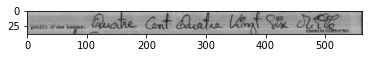

In [308]:
img=cv2.imread(r"C:/Users/Obertys/Desktop/OCR_cheques/cheques/cheque9.jpg")
im=check_extraction(img)[1]
cv2.imwrite('mont.png',im)
plt.imshow(im,"gray")

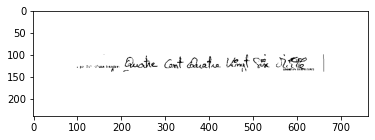

In [309]:
path="mont.png"
img=preprocess(path)


In [310]:
textLines=lineSegment(img)

imgList=wordSegment(textLines)

No. of Lines 1
42893.0
1228.0
72365.5
43483.0
67999.5
98753.5
2335.5
99556.5
13893.0
mean of area= 1228.0
No. of Words 5


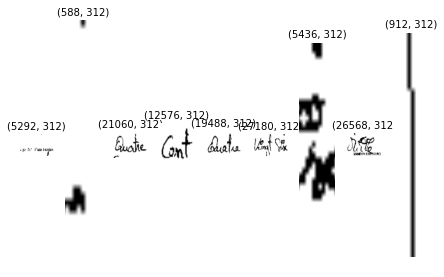

In [311]:
imgPix(imgList)

In [289]:
cv2.imwrite("im.png",img)

True

## Transformer les pixels parasites en pixels blancs pour avoir une bonne segmentation de mots

In [290]:
import numpy as np
import cv2
from skimage import util

img = cv2.imread(r"im.png")
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 127, 255, 0, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE) # Use cv2.CCOMP for two level hierarchy
# create an empty mask
mask = np.zeros(img.shape[:2], dtype=np.uint8)
for i, cnt in enumerate(contours):
    if hierarchy[0][i][3] != -1: # basically look for holes
        # if the size of the contour is less than a threshold (noise)
        if cv2.contourArea(cnt) < 25:
            # Fill the holes in the original image
            cv2.drawContours(img, [cnt], 0,(255,255,255), -1)

cv2.imshow("Mask", mask)
cv2.imshow("Img", img)
image = cv2.bitwise_not(img, img, mask=mask)
cv2.imshow("Mask", mask)
cv2.imshow("After", image)
cv2.imwrite('mont.png',image)
cv2.waitKey()
cv2.destroyAllWindows()

In [35]:
def imgPix(imgList):
    for i,img in enumerate(imgList):
        ax = plt.subplot(1, len(imgList), i+1)
        plt.imshow(img, cmap='binary')
        plt.title((np.sum(img==0),img.shape[0]),fontdict={'fontsize': 10, 'color': 'black'})
        plt.axis('off')
    plt.tight_layout()
    plt.show()
   